# **TOTAL RUN**

### **First Part: exploration of optimizer and training dataset size**

In [ ]:
import os, random, time, pickle
from pathlib import Path
from datetime import datetime

import numpy as np
import torch, torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.decomposition import PCA

# Reproducibility
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)


First, let's load cifar datas.  
Note that, a function to take some fraction of the training data is also defined here.

In [ ]:
# CIFAR‑10 transforms & datasets
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std  = (0.2023, 0.1994, 0.2010)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
])

data_root = './data'
train_dataset_full = datasets.CIFAR10(root=data_root, train=True, download=True, transform=transform_train)
val_dataset_full   = datasets.CIFAR10(root=data_root, train=False, download=True, transform=transform_test)

val_loader_full    = DataLoader(val_dataset_full, batch_size=128, shuffle=False, num_workers=2)

def get_subset_loader(dataset, subset_size, batch_size=64, shuffle=True, seed=42):
    if subset_size >= len(dataset):
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2)
    rng = np.random.default_rng(seed)
    idx = rng.choice(len(dataset), subset_size, replace=False)
    subset = Subset(dataset, idx)
    return DataLoader(subset, batch_size=batch_size, shuffle=shuffle, num_workers=2)


Then, we define our CNN

In [ ]:

class CIFAR10CNN(nn.Module):
    def __init__(self, dropout=0.25, dropout_classifier=0.5):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(dropout),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(dropout),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(dropout),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*4*4, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_classifier),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


Define a function to call 3 different optimizers:  
-SGD  
-ADAM  
-LION

In [7]:

def build_optimizer(name, model):
    if name == 'sgd':
        return torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True)
    if name == 'adam':
        return torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    if name == 'lion':
        from lion_pytorch import Lion
        return Lion(model.parameters(), lr=2e-4, weight_decay=5e-3)
    raise ValueError(name)


Let's define some function to get our model parameters as a vector.  
It will be useful for PCA loss landscape plots later.

In [ ]:
def weights_to_vec(model):
    return torch.nn.utils.parameters_to_vector(model.parameters()).detach().cpu()

def vec_to_weights(model, vec):
    vec = vec.to(next(model.parameters()).device)
    torch.nn.utils.vector_to_parameters(vec, model.parameters())


In [ ]:
# Here is our train loop for one epoch, and the eval function
# The last function is useful to calculate the loss, it will be used in the PCA loss landscape plots.

def train_one_epoch(epoch, train_load, model, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (images, targets) in enumerate(train_load):
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    print(f'Epoch {epoch:03d}  Train Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}')
    return epoch_loss

@torch.no_grad()
def evaluate(model, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, targets in val_loader_full:
        images, targets = images.to(device), targets.to(device)
        outputs = model(images)
        loss = criterion(outputs, targets)
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    loss = running_loss / total
    acc = correct / total
    return loss, acc


@torch.no_grad()
def compute_validation_loss(model, loader):
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    tot, n = 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        tot += loss_fn(model(x), y).item() * x.size(0)
        n += x.size(0)
    return tot / n


Now the big pca landscape plot function:  
-It performs a PCA  
-Then, It plots the loss variations along the two pricipal vector, making a nice loss landscape  
-Then, It adds the trajectories of the weights updates, projected in the 2D plae defined by the principal vectors  

In [ ]:

def plot_pca_with_contours(model, loader, weights_history, out_path=None, steps=21, pad_ratio=0.15, cmap='viridis', levels=40):
    print('Computing PCA landscape ...')
    W = torch.stack(weights_history).numpy()
    pca = PCA(n_components=2).fit(W)
    traj_2d = pca.transform(W)

    x_min, x_max = traj_2d[:,0].min(), traj_2d[:,0].max()
    y_min, y_max = traj_2d[:,1].min(), traj_2d[:,1].max()
    dx, dy = x_max - x_min, y_max - y_min
    al = np.linspace(x_min - dx*pad_ratio, x_max + dx*pad_ratio, steps)
    be = np.linspace(y_min - dy*pad_ratio, y_max + dy*pad_ratio, steps)

    w_star = torch.tensor(W[-1])
    d1, d2 = map(torch.tensor, pca.components_)   #the two principal vector
    loss_grid = np.zeros((steps, steps))          #the loss grid definition
    original = weights_to_vec(model)
    for i, a in enumerate(al):
        for j, b in enumerate(be):
            vec = w_star + a*d1 + b*d2
            vec_to_weights(model, vec)
            loss_grid[j,i] = compute_validation_loss(model, loader)
        print(f'    grid row {i+1}/{steps} done')

    vec_to_weights(model, original)
    fig, ax = plt.subplots(figsize=(5,4))
    cf = ax.contourf(al, be, loss_grid, levels=levels, cmap=cmap)
    ax.plot(traj_2d[:,0], traj_2d[:,1], 'w-o', lw=2, ms=4)
    fig.colorbar(cf, ax=ax, label='loss')
    ax.set_xlabel('PC-1'); ax.set_ylabel('PC-2')
    ax.set_title('Trajectory + loss contours')
    fig.tight_layout()

    if out_path is not None:
        fig.savefig(out_path, dpi=150)
    plt.show(); plt.close(fig)
    
    return {'alpha_vec': al, 'beta_vec': be, 'loss_grid': loss_grid, 'traj_2d': traj_2d}


**And finally, the main run experiment loop**  
When calling this function, the code will run the 3 optimizers, with 3 data training set size, and perform the PCA and calculate the loss curve.  
All the datas are then saved in some files, since it takes a lot of time to run (especially the PCA plots, since the computation of the loss on each points of the grid is very long).  


In [ ]:

NUM_EPOCHS = 100
OPTIMIZERS = ['sgd', 'adam', 'lion']
SIZES = [168, 1_000, 20_000]
out_root = Path('results')

def run_experiment(opt_name, subset_size, seed=42):
    print(f'\n===== [START] {opt_name.upper()} | n={subset_size} =====')
    out_dir = out_root / opt_name / f'n_{subset_size}'
    out_dir.mkdir(parents=True, exist_ok=True)
    
    # Load a subset of the training data (defined in the first cells)
    train_loader = get_subset_loader(train_dataset_full, subset_size, batch_size=128, shuffle=True, seed=seed)
    seed_everything(seed)

    # model, optimizer, etc
    model = CIFAR10CNN().to(device)
    optimizer = build_optimizer(opt_name, model)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    criterion = nn.CrossEntropyLoss()

    # define the quantities that we will save for the plots later
    weights_history = [weights_to_vec(model)]
    train_losses, val_losses, val_acc = [], [], []
    best_acc = 0.0
    for epoch in range(1, NUM_EPOCHS+1):
        tl = train_one_epoch(epoch, train_loader, model, optimizer, criterion)
        vl, va = evaluate(model, criterion)
        scheduler.step(vl)
        train_losses.append(tl)
        val_losses.append(vl)
        val_acc.append(va)
        print(f'Epoch {epoch:03d} | Val Loss: {vl:.4f} | Acc: {va:.4f}')
        if va > best_acc:
            best_acc = va
            torch.save(model.state_dict(), out_dir / 'best_model.pth')
        weights_history.append(weights_to_vec(model))   # the weights vector are stored here
        print("")

    # plots
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(train_losses, label='train')
    ax.plot(val_losses, label='val')
    ax.set_xlabel('epoch'); ax.set_ylabel('loss'); ax.set_title('Loss curves') 
    ax.legend(); ax.grid(True)
    fig.tight_layout(); fig.savefig(out_dir / 'loss_curves.png', dpi=150)
    plt.show(); plt.close(fig)
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(val_acc, label='val acc')
    ax.set_xlabel('epoch'); ax.set_ylabel('accuracy'); ax.set_title('Accuracy curve')
    ax.legend(); ax.grid(True)
    fig.tight_layout(); fig.savefig(out_dir / 'accuracy_curve.png', dpi=150)
    plt.show(); plt.close(fig)

    # PCA plot (takes a long time !!!)
    pca_dict = plot_pca_with_contours(model, val_loader_full, weights_history, out_path=out_dir/'pca_contour.png', steps=11, pad_ratio=0.2)

    # save torch dict
    torch.save({
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_acc': val_acc,
        'weights_history': weights_history,
        **pca_dict,
    }, out_dir / 'results.pt')
    print(f'===== [DONE] {opt_name.upper()} | n={subset_size} =====')


In [ ]:
# /!\ CAREFUL /!\ -> Long‑running cell: launches the full 3×3 sweep
for opt in OPTIMIZERS:
    for size in SIZES:
        run_experiment(opt, size)

### **Loss/accuracy plots & PCA landscape plot**

In [ ]:
# =====================================================
#   Figure 1 – Loss & Accuracy · 3 opt · 3 tailles  
# =====================================================  
                       
import matplotlib.pyplot as plt
import torch, numpy as np
from pathlib import Path

optims = ['sgd', 'adam', 'lion']
sizes  = [168, 1000, 20000]
root   = Path('results')
#colors = ['tab:blue', 'tab:orange', 'tab:green']   # 1 couleur / taille
#colors = ['#4C72B0', '#DD8452', '#55A868']  # soft green
colors = [ "#e82323", "#d6b10c",  "#1ad138"]  # vibrant green


fig, axes = plt.subplots(2, 3, figsize=(15, 6), sharex='col', tight_layout=False)

for j, opt in enumerate(optims):
    for k, n in enumerate(sizes):
        p = root / opt / f'n_{n}' / 'results.pt'
        if not p.exists(): continue
        d = torch.load(p, map_location='cpu', weights_only=False)
        x = np.arange(1, len(d['train_losses']) + 1)

        # --- ligne 0 : loss -------------------------------------------------
        axes[0, j].plot(x, d['train_losses'], color=colors[k], label=f'Train n={n}')
        axes[0, j].plot(x, d['val_losses'],  color=colors[k], ls='--', label=f'Val n={n}')

        # --- ligne 1 : accuracy --------------------------------------------
        axes[1, j].plot(x, d['val_acc'], color=colors[k], label=f'n={n}')
        axes[1, j].set_yticks(np.linspace(0.1, 0.9, 9))

    axes[0, j].set_title(opt.upper(), pad=6)
    axes[1, j].set_xlabel('Epoch')
    axes[0, j].set_ylabel('Loss'     if j == 0 else '')
    axes[1, j].set_ylabel('Accuracy' if j == 0 else '')
    for a in axes[:, j]:
        a.grid(alpha=.3)

# légende unique centrée sous la 1e ligne
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=3, loc='upper center', bbox_to_anchor=(0.5, 1.09))
fig.subplots_adjust(wspace=0.25, hspace=0.15, top=0.90)
plt.savefig("loss_accuracy.pdf", format='pdf', bbox_inches='tight')
plt.show()


In [ ]:
# =============================================================================
#   Figure 2 – Contours PCA + trajectoire (3 opt × 3 tailles)              
# =============================================================================

import matplotlib.pyplot as plt, torch
import numpy as np
from pathlib import Path
from matplotlib.ticker import FormatStrFormatter

optims = ['sgd', 'adam', 'lion']
sizes  = [168, 1000, 20000]
root   = Path('results')

# Mettre LOG = True si on souhaite mettre une échelle logharithmique pour mieux distinguer le landscape (les pics de hautes valeurs peuvent empêcher de bien voir la zone du minimum)
# Mettre CONTOUR = False pour désactiver le contour restreint à une certaine vartiation du loss \in [min(loss), min(loss) + epsilon]
LOG=False
CONTOUR=True

fig, axes = plt.subplots(3, 3, figsize=(15, 14))  
wspace, hspace = 0.19, 0.005                       
fig.subplots_adjust(wspace=wspace, hspace=hspace)


for i, n in enumerate(sizes):
    for j, opt in enumerate(optims):
        ax = axes[i, j]
        f  = root / opt / f'n_{n}' / 'results.pt'
        if not f.exists():
            ax.text(0.5, .5, 'missing', ha='center', va='center')
            ax.set_xticks([]); ax.set_yticks([])
            continue

        d      = torch.load(f, map_location='cpu', weights_only=False)
        al, be = d['alpha_vec'], d['beta_vec']
        grid   = d['loss_grid']
        traj   = d['traj_2d']

        # ----- contours ----------------------------------------------------
        maxrange=0.09
        if CONTOUR:
            cf = ax.contourf(al, be, grid, levels=(np.min(grid) + np.arange(0, 1, 0.05)), cmap='viridis')
        else:
            cf     = ax.contourf(al, be,        grid , 60, cmap='viridis')
            if LOG:
                cf = ax.contourf(al, be, np.log(grid), 50, cmap='viridis')
        # ----- trajectoire -------------------------------------------------
        ax.plot(traj[:, 0], traj[:, 1], color='white', lw=1.8)             # ligne
        ax.scatter(traj[:-1, 0], traj[:-1, 1], s=10, c='white', zorder=3)  # points blancs
        ax.scatter(traj[-1, 0],  traj[-1, 1], s=25, c='red',  edgecolors='white',
                   linewidths=0.8, zorder=4)                               # dernier point
        if CONTOUR:
            col="#BABABA"
            ax.plot(traj[:, 0], traj[:, 1], color=col, lw=1.8)             # ligne
            ax.scatter(traj[:-1, 0], traj[:-1, 1], s=10, c=col, zorder=3)  # points blancs
            ax.scatter(traj[-1, 0],  traj[-1, 1], s=25, c='red',  edgecolors=col,
                   linewidths=0.8, zorder=4)  
            #ax.scatter(traj[0, 0],  traj[0, 1], s=25, c='blue',  edgecolors='k',
            #       linewidths=0.8, zorder=4)   

        #square fig
        #ax.set_aspect('equal')
        ax.set_box_aspect(1)  # <-- Square tile shape
        # axes + labels
        if i==2:
            ax.set_xlabel('PC-1')
        #ax.set_ylabel('PC-2')
        ax.tick_params(labelsize=8)
        if i == 0:
            ax.set_title(opt.upper(), fontsize=11, pad=4)
        if j == 0:
            ax.set_ylabel(f'PC-2\nn={n}', fontsize=10)

        # petite colorbar individuelle collée au subplot
        #plt.colorbar(cf, ax=ax, fraction=0.035, pad=0.03, ticks=[]).set_label('loss', fontsize=8)
        if CONTOUR:
            cbar = plt.colorbar(cf, ax=ax, fraction=0.042, pad=0.03) #, ticks=np.linspace(np.min(grid), maxrange, 5))
        else:
            if LOG:
                cbar = plt.colorbar(cf, ax=ax, fraction=0.042, pad=0.03, ticks=np.linspace(np.min(np.log(grid)), np.max(np.log(grid)), 5))
            else :
                cbar = plt.colorbar(cf, ax=ax, fraction=0.042, pad=0.03, ticks=np.linspace(np.min(grid), np.max(grid), 5))
        if j == 2:
            if LOG:
                cbar.set_label('log(loss)', fontsize=11)
            else:
                cbar.set_label('loss', fontsize=11)
        cbar.ax.tick_params(labelsize=8)  # Set smaller tick label font size
        cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  # <-- 1 decimal place

if CONTOUR:
    plt.savefig("total_pca_fig_contour.pdf", format='pdf', bbox_inches='tight')
else:
    if LOG:
        plt.savefig("total_pca_fig_log.pdf", format='pdf', bbox_inches='tight')
    else:
        plt.savefig("total_pca_fig.pdf", format='pdf', bbox_inches='tight')
plt.show()


### **Second Part: exploration of data augmentation**

After we saw adam leads to the best results for limited datas (see the loss curves and the accuracy curves), we decide to continue with ADAM optimizer.  

We put ourselves in this problem:  
What if we only have limited amount of datas ? What could we do to have the best accuracy possible ?  

We tried some hyperparameter explorations, but since there were so many parameter we chose to focus on data augmentation and transfert learning.  

In [1]:
# ------------------ Cell 0 : train the CIFAR-100 backbone for transfert learning ------------------
import subprocess, sys

print("Training the CIFAR-100 backbone (train_model_cifar100.py)...")
subprocess.run([sys.executable, "train_model_cifar100.py"], check=True)
print("Pre-training finished — model_cifar100.pt should now exist.\n")

#approx 30 min train


Training the CIFAR-100 backbone (train_model_cifar100.py)...
Pre-training finished — model_cifar100.pt should now exist.



In [2]:
# ------------------ Cell 1 : run every script with 3 subset sizes ------------------
import subprocess, sys, re
from pathlib import Path

# -------- CONFIG --------
PY_FILES = [
    "data_augmentation_flipwCifar100.py",
    "data_augmentation_flip&crop&friends.py",
    #"data_augmentation_color_jittered.py",  
    #"data_augmentation_rotation.py",
    "project_base.py",
    #"data_augmentation_crop.py",
    "data_augmentation_flip.py", 
    #"data_augmentation_flip&crop.py",
    "project_wCifar100.py",
]

SUBSET_SIZES = [30, 100, 300, 500, 1000]
NUM_PATTERN = re.compile(r"NUM_TRAIN_SAMPLES\s*=\s*\d+")  # finds the constant

for py in PY_FILES:
    src = Path(py)
    original_code = src.read_text()

    for n in SUBSET_SIZES:
        # create a throw-away copy with NUM_TRAIN_SAMPLES set to `n`
        tmp_path = src.with_suffix(f".{n}.tmp.py")
        tmp_code = NUM_PATTERN.sub(f"NUM_TRAIN_SAMPLES = {n}", original_code, count=1)
        tmp_path.write_text(tmp_code)

        print(f"Running {src.name} with NUM_TRAIN_SAMPLES={n}")
        subprocess.run([sys.executable, str(tmp_path)], check=True)

        tmp_path.unlink()   # remove the temporary file


Running data_augmentation_flipwCifar100.py with NUM_TRAIN_SAMPLES=30
Running data_augmentation_flipwCifar100.py with NUM_TRAIN_SAMPLES=100
Running data_augmentation_flipwCifar100.py with NUM_TRAIN_SAMPLES=300
Running data_augmentation_flipwCifar100.py with NUM_TRAIN_SAMPLES=500
Running data_augmentation_flipwCifar100.py with NUM_TRAIN_SAMPLES=1000
Running data_augmentation_flip&crop&friends.py with NUM_TRAIN_SAMPLES=30
Running data_augmentation_flip&crop&friends.py with NUM_TRAIN_SAMPLES=100
Running data_augmentation_flip&crop&friends.py with NUM_TRAIN_SAMPLES=300
Running data_augmentation_flip&crop&friends.py with NUM_TRAIN_SAMPLES=500
Running data_augmentation_flip&crop&friends.py with NUM_TRAIN_SAMPLES=1000
Running project_base.py with NUM_TRAIN_SAMPLES=30
Running project_base.py with NUM_TRAIN_SAMPLES=100
Running project_base.py with NUM_TRAIN_SAMPLES=300
Running project_base.py with NUM_TRAIN_SAMPLES=500
Running project_base.py with NUM_TRAIN_SAMPLES=1000
Running data_augmentation

Current working directory: c:\Users\herma\OneDrive\Bureau\Etudes EPFL\Ma4\MLopt\optim_ML_project\clement\optim_ML_project
fichier : flip, train data size : 30 --- Accuracy : 0.208 +- 0.016
fichier : flip, train data size : 100 --- Accuracy : 0.292 +- 0.022
fichier : flip, train data size : 300 --- Accuracy : 0.408 +- 0.018
fichier : flip, train data size : 500 --- Accuracy : 0.458 +- 0.014
fichier : flip, train data size : 1000 --- Accuracy : 0.555 +- 0.013
fichier : flip&crop&friends, train data size : 30 --- Accuracy : 0.223 +- 0.013
fichier : flip&crop&friends, train data size : 100 --- Accuracy : 0.311 +- 0.024
fichier : flip&crop&friends, train data size : 300 --- Accuracy : 0.430 +- 0.015
fichier : flip&crop&friends, train data size : 500 --- Accuracy : 0.488 +- 0.007
fichier : flip&crop&friends, train data size : 1000 --- Accuracy : 0.590 +- 0.017
fichier : flipwCifar100, train data size : 30 --- Accuracy : 0.363 +- 0.025
fichier : flipwCifar100, train data size : 100 --- Accura

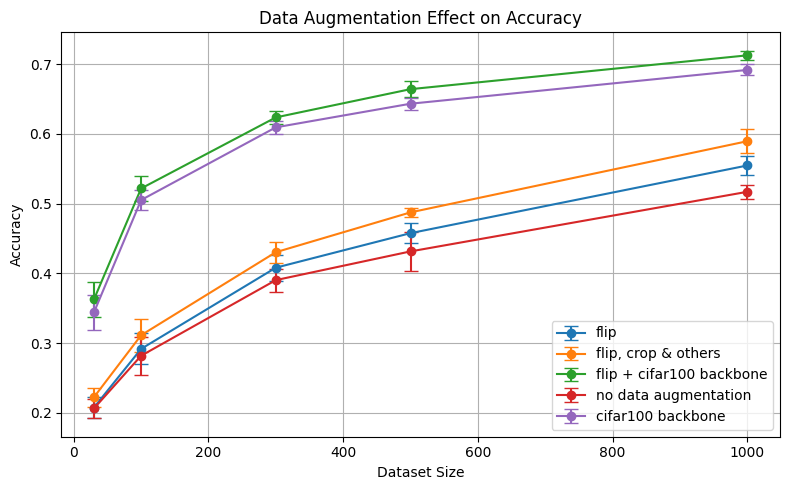

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Configuration
augmentation_types = ["flip", "flip&crop&friends", "flipwCifar100", "project_base", "project_wCifar100"]          #["crop", "flip", "flip&crop", "project_base", "project_wCifar100", "project_wCifar100_freeze"]
dataset_sizes =  SUBSET_SIZES         #[100, 500, 1000]
base_filename = "results_data_augmentation_{}.{}.tmp_{}.txt"
labels = ["flip", "flip, crop & others", "flip + cifar100 backbone", "no data augmentation", "cifar100 backbone"]
# Storage
results = {}

cwd = os.getcwd()
print("Current working directory:", cwd)

# Load data
for aug in augmentation_types:
    means = []
    stds  = []
    sizes = []
    if aug == "project_base":
        base_filename = "results_{}.{}.tmp_{}.txt"
    # if aug == "project_wCifar100" or "project_wCifar100_freeze" :
    #     base_filename = "results_{}_{}.txt"
    for size in dataset_sizes:
        filename = base_filename.format(aug, size, size)
        if os.path.exists(filename):
            with open(filename, 'r') as f:
                values = np.array(list(map(float, f.read().strip().split())))
                means.append(np.mean(values))
                stds.append(np.std(values))
                sizes.append(size)
                print(f"fichier : {aug}, train data size : {size} --- Accuracy : {means[-1]:.3f} +- {stds[-1]:.3f}")
    results[aug] = (sizes, means, stds)

# Plotting
plt.figure(figsize=(8, 5))
for i, (aug, (sizes, means, stds)) in enumerate(results.items()):
    plt.errorbar(sizes, means, yerr=stds, label=labels[i], marker='o', capsize=5)

plt.xlabel("Dataset Size")
plt.ylabel("Accuracy")
plt.title("Data Augmentation Effect on Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("data_augm.pdf", format='pdf', bbox_inches='tight')
plt.show()